In [1]:
# 1. Imports & Config
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# --- INSTALL & IMPORT nflreadpy ---
try:
    import nflreadpy as nfl
except ImportError:
    print("📦 Installing nflreadpy...")
    !pip install nflreadpy
    import nflreadpy as nfl

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- SETUP PATH ---
PROJECT_ROOT = '/content/drive/MyDrive/NFL_Prediction_System'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import config

# --- STRESS TEST CONFIG ---
VALIDATION_SEASON = 2025
LAG_SEASON = 2024  # Needed for rolling windows to have context
print(f"✅ Configured for Stress Test: {VALIDATION_SEASON} Season")

📦 Installing nflreadpy...
Mounted at /content/drive
✅ Configured for Stress Test: 2025 Season


In [2]:
# 2. Fetch & Engineer 2025 Data (Replicating Pipeline)
print(f"{'-'*30}\nFetching Data for {LAG_SEASON} & {VALIDATION_SEASON}...")

# 1. Load Data
pbp = nfl.load_pbp(seasons=[LAG_SEASON, VALIDATION_SEASON]).to_pandas()
pbp = pbp[pbp['season_type'] == 'REG']
schedule = nfl.load_schedules().to_pandas()
schedule = schedule[
    (schedule['season'].isin([LAG_SEASON, VALIDATION_SEASON])) &
    (schedule['game_type'] == 'REG')
]

# 2. Feature Construction (The "Brain")
print("   -> Reconstructing Feature Matrix...")
pbp['pass_epa'] = np.where(pbp['play_type'] == 'pass', pbp['epa'], np.nan)
pbp['rush_epa'] = np.where(pbp['play_type'] == 'run', pbp['epa'], np.nan)
pbp['turnover'] = pbp['fumble_lost'] + pbp['interception']

# Aggregations
game_stats = pbp.groupby(['season', 'week', 'game_id', 'posteam']).agg({
    'epa': 'mean', 'success': 'mean', 'pass_epa': 'mean', 'rush_epa': 'mean', 'turnover': 'sum'
}).reset_index()
game_stats.columns = ['season', 'week', 'game_id', 'team', 'off_epa_per_play', 'off_success_rate', 'off_pass_epa', 'off_run_epa', 'off_turnovers']

def_stats = game_stats.copy().rename(columns={
    'team': 'defteam', 'off_epa_per_play': 'def_epa_per_play', 'off_success_rate': 'def_success_rate',
    'off_pass_epa': 'def_pass_epa', 'off_run_epa': 'def_run_epa', 'off_turnovers': 'def_turnovers_forced'
})

# Schedule & Rest
schedule['gameday'] = pd.to_datetime(schedule['gameday'])
team_sched = pd.concat([
    schedule[['game_id', 'season', 'week', 'home_team', 'gameday']].rename(columns={'home_team': 'team'}),
    schedule[['game_id', 'season', 'week', 'away_team', 'gameday']].rename(columns={'away_team': 'team'})
]).sort_values(['team', 'gameday'])
team_sched['rest_days'] = (team_sched['gameday'] - team_sched.groupby('team')['gameday'].shift(1)).dt.days.fillna(7)

# Merging
base_games = pd.concat([
    schedule[['game_id', 'season', 'week', 'home_team', 'result', 'spread_line']].rename(columns={'home_team': 'team'}).assign(is_home=1, target_win=lambda x: (x.result > 0).astype(int)),
    schedule[['game_id', 'season', 'week', 'away_team', 'result', 'spread_line']].rename(columns={'away_team': 'team'}).assign(is_home=0, target_win=lambda x: (x.result < 0).astype(int))
])

base_games = base_games.merge(game_stats, on=['game_id', 'team'], how='left')
opp_map = pd.concat([
    schedule[['game_id', 'home_team', 'away_team']].rename(columns={'home_team': 'team', 'away_team': 'opponent'}),
    schedule[['game_id', 'away_team', 'home_team']].rename(columns={'away_team': 'team', 'home_team': 'opponent'})
])
base_games = base_games.merge(opp_map, on=['game_id', 'team'], how='left')
base_games = base_games.merge(def_stats, left_on=['game_id', 'opponent'], right_on=['game_id', 'defteam'], how='left')
base_games = base_games.merge(team_sched[['game_id', 'team', 'rest_days']], on=['game_id', 'team'], how='left')

# Rolling Features
rolling_metrics = [
    'off_epa_per_play', 'off_success_rate', 'off_pass_epa', 'off_run_epa', 'off_turnovers',
    'def_epa_per_play', 'def_success_rate', 'def_pass_epa', 'def_run_epa', 'def_turnovers_forced'
]
windows = [3, 5, 8]
base_games = base_games.sort_values(['team', 'season', 'week'])
grouped = base_games.groupby('team')

for window in windows:
    for col in rolling_metrics:
        base_games[f'{col}_roll{window}'] = grouped[col].shift(1).rolling(window=window, min_periods=1).mean()

# 2025 Matchups
val_2025 = base_games[(base_games['season'] == 2025) & (base_games['is_home'] == 1)].copy()
away_2025 = base_games[(base_games['season'] == 2025) & (base_games['is_home'] == 0)].copy()
final_df = val_2025.merge(away_2025, on='game_id', suffixes=('', '_away'))

# Differentials
for window in windows:
    for col in rolling_metrics:
        final_df[f'home_{col}_roll{window}'] = final_df[f'{col}_roll{window}']
        final_df[f'away_{col}_roll{window}'] = final_df[f'{col}_roll{window}_away']
        if 'off_' in col:
            def_col = col.replace('off_', 'def_')
            if col == 'off_turnovers': def_col = 'def_turnovers_forced'
            if f'{def_col}_roll{window}_away' in final_df.columns:
                final_df[f'home_{col}_matchup_roll{window}'] = final_df[f'{col}_roll{window}'] - final_df[f'{def_col}_roll{window}_away']
                final_df[f'away_{col}_matchup_roll{window}'] = final_df[f'{col}_roll{window}_away'] - final_df[f'{def_col}_roll{window}']

final_df['home_rest'] = final_df['rest_days']
final_df['away_rest'] = final_df['rest_days_away']
final_df['rest_advantage'] = final_df['home_rest'] - final_df['away_rest']

print(f"✅ 2025 Data Ready: {final_df.shape}")

------------------------------
Fetching Data for 2024 & 2025...
   -> Reconstructing Feature Matrix...
✅ 2025 Data Ready: (195, 202)


/tmp/ipython-input-2877606176.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['rest_advantage'] = final_df['home_rest'] - final_df['away_rest']


In [3]:
# 3. Load Models & Predict (War Room)
print(f"{'-'*30}\nLoading AI Models...")

# Load NV Champion
nv_path = config.MODELS_DIR / "ensemble" / "nv_nuclear_ensemble.pkl"
with open(nv_path, 'rb') as f:
    nv_model = pickle.load(f)

# Load Scaler
with open(config.MODELS_DIR / "baseline" / "NV" / "nv_scaler.pkl", 'rb') as f:
    nv_scaler = pickle.load(f)

# Align Features
try:
    nv_features = nv_model.estimators_[0].feature_names_in_
except:
    # Fallback if attribute missing
    ref_df = pd.read_parquet(config.FEATURES_DIR / 'features_master_2003_2023.parquet')
    drop_cols_nv = ['game_id', 'season', 'week', 'home_team', 'away_team', 'home_score', 'away_score', 'home_win', 'home_cover', 'over_hit', 'spread_line', 'total_line']
    nv_features = [c for c in ref_df.columns if c not in drop_cols_nv]

X_2025 = pd.DataFrame(0, index=final_df.index, columns=nv_features)
for col in nv_features:
    if col in final_df.columns:
        X_2025[col] = final_df[col]

# Predict
print("🤖 Generating Predictions...")
X_scaled = nv_scaler.transform(X_2025)
nv_probs = nv_model.predict_proba(X_scaled)[:, 1]
vegas_probs = 1 / (1 + 10 ** (final_df['spread_line'] / 14.5)) # Implied Prob

# War Room DataFrame
war_room = final_df[['season', 'week', 'game_id', 'team', 'opponent', 'spread_line', 'target_win']].copy()
war_room.rename(columns={'team': 'Home', 'opponent': 'Away', 'target_win': 'Actual_Home_Win'}, inplace=True)
war_room['NV_Prob'] = nv_probs
war_room['Vegas_Prob'] = vegas_probs
war_room['Edge'] = war_room['NV_Prob'] - war_room['Vegas_Prob']
war_room = war_room[war_room['week'] >= 3].reset_index(drop=True)

------------------------------
Loading AI Models...
🤖 Generating Predictions...


------------------------------Running 2025 'Profit Taker' Simulation------------------------------
💰 PROFIT TAKING! Week 4.0: Withdrew $506.91
💰 PROFIT TAKING! Week 9.0: Withdrew $517.68

📊 2025 SEASON RESULTS (Profit Taker Strategy):
   Starting Cash:    $400
   Cash on Hand:     $514.82
   Total Withdrawn:  $1024.59
   Total Equity:     $1539.42
   Realized ROI:     284.85%


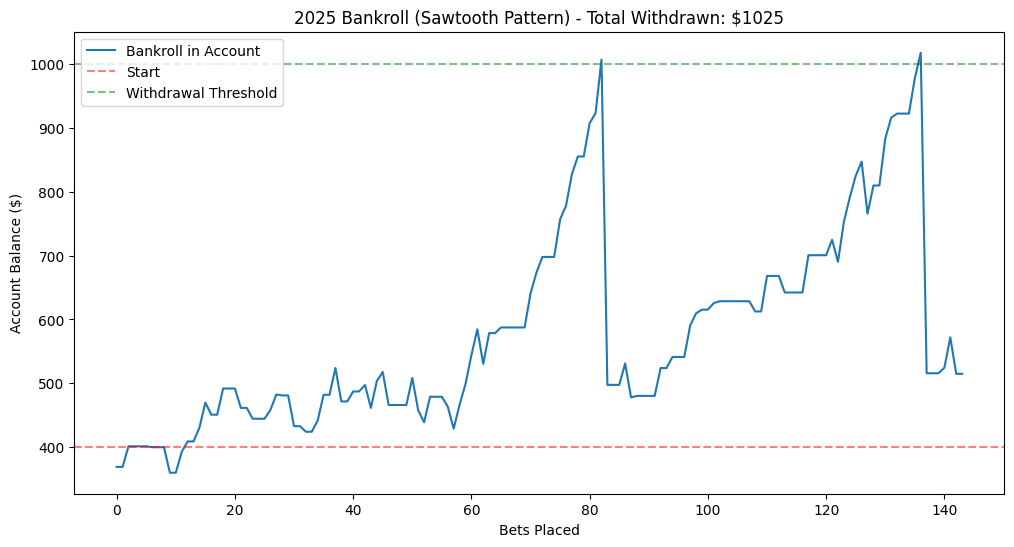

In [4]:
# 4. The "Salary Cap" Simulation (Reset at $2k)
print(f"{'-'*30}Running 2025 'Profit Taker' Simulation{'-'*30}")

# --- SIMULATION RULES ---
STARTING_BANKROLL = 400
RESET_THRESHOLD = 1000          # If bankroll hits this...
RESET_TO = RESET_THRESHOLD / 2  # ...withdraw profit and reset to this.
KELLY_FRACTION = 0.5   # fractional Kelly
MIN_EDGE = 0.05
MAX_BET_PCT = 0.1

bankroll = STARTING_BANKROLL
total_withdrawn = 0
history = []
withdrawals = [] # Track when we took money out

for idx, row in war_room.iterrows():
    # 1. Reset Check (The "Salary Cap")
    if bankroll >= RESET_THRESHOLD:
        amount_to_withdraw = bankroll - RESET_TO
        bankroll = RESET_TO
        total_withdrawn += amount_to_withdraw
        withdrawals.append(idx) # Mark this index
        print(f"💰 PROFIT TAKING! Week {row['week']}: Withdrew ${amount_to_withdraw:.2f}")

    # 2. Strategy Logic
    if abs(row['Edge']) < MIN_EDGE:
        continue

    bet_on_home = row['Edge'] > 0
    my_prob = row['NV_Prob'] if bet_on_home else (1 - row['NV_Prob'])

    # Quarter Kelly Size
    b = 0.909
    p = my_prob
    q = 1 - p
    kelly_pct = (b * p - q) / b
    wager_pct = max(0, min(kelly_pct * KELLY_FRACTION, MAX_BET_PCT))
    wager_amount = bankroll * wager_pct

    # 3. Outcome
    did_home_win = row['Actual_Home_Win'] == 1
    won_bet = (bet_on_home and did_home_win) or (not bet_on_home and not did_home_win)

    if won_bet:
        bankroll += wager_amount * b
    else:
        bankroll -= wager_amount

    history.append(bankroll)

# --- RESULTS REPORT ---
equity = bankroll + total_withdrawn
roi = ((equity - STARTING_BANKROLL) / STARTING_BANKROLL) * 100

print(f"\n📊 2025 SEASON RESULTS (Profit Taker Strategy):")
print(f"   Starting Cash:    ${STARTING_BANKROLL}")
print(f"   Cash on Hand:     ${bankroll:.2f}")
print(f"   Total Withdrawn:  ${total_withdrawn:.2f}")
print(f"   Total Equity:     ${equity:.2f}")
print(f"   Realized ROI:     {roi:.2f}%")

# Plotting the "Sawtooth"
plt.figure(figsize=(12, 6))
plt.plot(history, label='Bankroll in Account')
plt.axhline(y=STARTING_BANKROLL, color='r', linestyle='--', alpha=0.5, label='Start')
plt.axhline(y=RESET_THRESHOLD, color='g', linestyle='--', alpha=0.5, label='Withdrawal Threshold')
plt.title(f"2025 Bankroll (Sawtooth Pattern) - Total Withdrawn: ${total_withdrawn:.0f}")
plt.xlabel("Bets Placed")
plt.ylabel("Account Balance ($)")
plt.legend(loc='upper left')
plt.show()